# Overview

Once an agriculture-based economy, today Bali heavily relies on Tourism industry as the main source of their GDP. Bali is so touristy that it makes Bali somehow look like a different country rather than part of Indonesia. Here you can find amazing beaches(Kuta, Seminyak, Sanur), wonderful temples(Tanah lot, Uluwatu), and unique culture combined with an international vibe in one small island.

Traditionally Australia is the main source of international tourists. But in the past few years the number of tourists from China increased significantly and it became very close to Australia’s number. I think this trend will continue and we will see more people from China and other Asian countries choose Bali as a holiday destination.

This is the reason why the government needs to act in order to catch up with the trend. If the government can forecast accurately the number of international arrivals in the future, they will have more time to prepare for the infrastructure such as hotels, bars, and restaurants. Machine learning technique is one of the solution that can be implemented and that’s what I am doing in this project.


#  Goal

The main objective of this project is to predict the number of foreign tourist arrivals every month in Bali.

# Data Collection & Preparation

In [1]:
import pandas as pd
import requests
from lxml import html
from bs4 import BeautifulSoup

## Weather

Monthly weather information was scraped from Denpasar’s wikipedia page using BeautifulSoup. The temperature data was not really clean in the beginning, it has both celsius and fahrenheit values in one cell. So I decided to keep Celsius value while removing Fahrenheit value.

In [2]:
url = "https://en.wikipedia.org/wiki/Denpasar"
response = requests.get(url).text
soup = BeautifulSoup(response, 'lxml')
my_table = soup.find('table',{'class':'wikitable collapsible'})
values = my_table.findAll('td') 

climate = []
for value in values:
    climate.append(value.get_text())
count=0
df_temperature = pd.DataFrame()
while count < 12:
    df_temperature = df_temperature.append({'average_high_celsius' : climate[count], 'daily_mean_celsius' : climate[count+13], 'average_low_celsius' : climate[count+26], 'average_precipitation_mm' : climate[count+39], 'average_precipitation_days' : climate[count+52], 'average_relative_hummidity' : climate[count+65]} ,ignore_index=True)
    count += 1
    
#remove farenheit values
df_temperature['average_high_celsius'] = df_temperature['average_high_celsius'].str.replace('\n','').str.replace(r"\(.*\)","")
df_temperature['average_low_celsius'] = df_temperature['average_low_celsius'].str.replace('\n','').str.replace(r"\(.*\)","") 
df_temperature['average_precipitation_mm'] = df_temperature['average_precipitation_mm'].str.replace('\n','').str.replace(r"\(.*\)","") 
df_temperature['daily_mean_celsius'] = df_temperature['daily_mean_celsius'].str.replace('\n','').str.replace(r"\(.*\)","") 
df_temperature['average_relative_hummidity'] = df_temperature['average_relative_hummidity'].str.replace('\n','')
df_temperature['average_precipitation_days'] = df_temperature['average_precipitation_days'].str.replace('\n','')

df_temperature['month'] = df_temperature.index + 1



## Google Trends

According to wikipedia, Google Trends is a website by Google that analyzes the popularity of top search queries in Google Search across various regions and languages. The website uses graphs to compare the search volume of different queries over time. Since I only pick 7 countries for this project, therefore I only obtain weekly search interest data for the search term ‘bali’ from those 7 countries.

Since the google trend data was in a weekly timeframe, I split the data into groups based on month so it can be merged with other data to create one single dataset.

In [3]:
def country_origin(csv_file,country):
    df = pd.read_csv(csv_file).reset_index()
    df['country'] = country
    df = df.iloc[1:]
    
    return df
    
df_trend_china = country_origin('china.csv','china')
df_trend_australia = country_origin('australia.csv','australia')
df_trend_malaysia = country_origin('malaysia.csv','malaysia')
df_trend_unitedstates = country_origin('unitedstates.csv','united_states')
df_trend_japan = country_origin('japan.csv','japan')
df_trend_southkorea = country_origin('southkorea.csv','south_korea')
df_trend_india = country_origin('india.csv','india')

df_trend = pd.concat([df_trend_china, df_trend_australia, df_trend_malaysia, df_trend_unitedstates, df_trend_japan, df_trend_southkorea, df_trend_india])

In [4]:
df_trend.columns = ['date','search_interest','country']
df_trend['month'] = df_trend['date'].str.slice(start=5, stop=7)
df_trend['month'] = df_trend['month'].str.lstrip('0').astype(int)
df_trend_monthly = df_trend.groupby(['country','month'])['search_interest'].sum().reset_index() #group by country and month

df_trend_monthly

,country,month,search_interest
0,australia,1,88867776
1,australia,2,78767574
2,australia,3,6770747371
3,australia,4,69769078
4,australia,5,77759176
5,australia,6,7476787981
6,australia,7,841009495
7,australia,8,81867984
8,australia,9,7982868179
9,australia,10,77847774


## Foreign Tourist Arrivals

We can access the number of foreign tourist arrivals every month from the official website of the Ministry of Tourism and Creative Economy Republic of Indonesia. For this project I only use the total numbers of arrivals from Malaysia, India, South Korea, Japan, United States, China, and Australia at Ngurah Rai International Airport between January — December 2019. The data is only available on PDF format so I decided to type manually all information that I need.

In [5]:
df_visitors = pd.read_csv('wisman_2019.csv')


## Merge Dataframes 

In [6]:
df_visitors_trend = pd.merge(df_visitors, df_trend_monthly,how='left', on=['month', 'country'])
df_full = pd.merge(df_visitors_trend, df_temperature,how='left', on=['month'])
df_full['month'] = df_full['month'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
df_full

,country,month,visitors,search_interest,average_high_celsius,average_low_celsius,average_precipitation_days,average_precipitation_mm,average_relative_hummidity,daily_mean_celsius
0,malaysia,jan,10405,71667960,33.0,24.1,19,345,85,28.6
1,india,jan,28946,87848188,33.0,24.1,19,345,85,28.6
2,japan,jan,16792,78646582,33.0,24.1,19,345,85,28.6
3,south_korea,jan,15373,54764231,33.0,24.1,19,345,85,28.6
4,china,jan,115473,22262956,33.0,24.1,19,345,85,28.6
5,united_states,jan,17209,68717259,33.0,24.1,19,345,85,28.6
6,australia,jan,91561,88867776,33.0,24.1,19,345,85,28.6
7,malaysia,feb,14441,72737371,33.4,24.2,17,274,85,28.8
8,india,feb,28809,84798281,33.4,24.2,17,274,85,28.8
9,japan,feb,20665,59476260,33.4,24.2,17,274,85,28.8


# Feature Engineering 

## One Hot Encoding 

There are two categorical features (month and country) in the dataset, therefore I need to convert all categories from rows into columns. This technique is called One Hot Encoding.

In [7]:
countries = pd.get_dummies(df_full['country'])
months = pd.get_dummies(df_full['month'])

df_full = pd.concat([df_full, countries, months], axis=1)

df_full = df_full.drop(df_full.columns[[0, 1]], axis=1)
df_full

,visitors,search_interest,average_high_celsius,average_low_celsius,average_precipitation_days,average_precipitation_mm,average_relative_hummidity,daily_mean_celsius,australia,china,...,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,10405,71667960,33.0,24.1,19,345,85,28.6,0,0,...,0,0,1,0,0,0,0,0,0,0
1,28946,87848188,33.0,24.1,19,345,85,28.6,0,0,...,0,0,1,0,0,0,0,0,0,0
2,16792,78646582,33.0,24.1,19,345,85,28.6,0,0,...,0,0,1,0,0,0,0,0,0,0
3,15373,54764231,33.0,24.1,19,345,85,28.6,0,0,...,0,0,1,0,0,0,0,0,0,0
4,115473,22262956,33.0,24.1,19,345,85,28.6,0,1,...,0,0,1,0,0,0,0,0,0,0
5,17209,68717259,33.0,24.1,19,345,85,28.6,0,0,...,0,0,1,0,0,0,0,0,0,0
6,91561,88867776,33.0,24.1,19,345,85,28.6,1,0,...,0,0,1,0,0,0,0,0,0,0
7,14441,72737371,33.4,24.2,17,274,85,28.8,0,0,...,0,1,0,0,0,0,0,0,0,0
8,28809,84798281,33.4,24.2,17,274,85,28.8,0,0,...,0,1,0,0,0,0,0,0,0,0
9,20665,59476260,33.4,24.2,17,274,85,28.8,0,0,...,0,1,0,0,0,0,0,0,0,0


# Feature Selection

Feature selection is important especially when you have too many features to begin with. By reducing the number of features hopefully it can also improve the performance of the model. There are 3 common methods of doing feature selection: Filter, wrapper, and embedded. For this project I choose a filter method by using a Pearson correlation matrix.

My goal in this step is to find features that are too similar to each other and keep only one of them. Below is the Pearson correlation heatmap to see the correlation of all features in the weather dataset.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sb

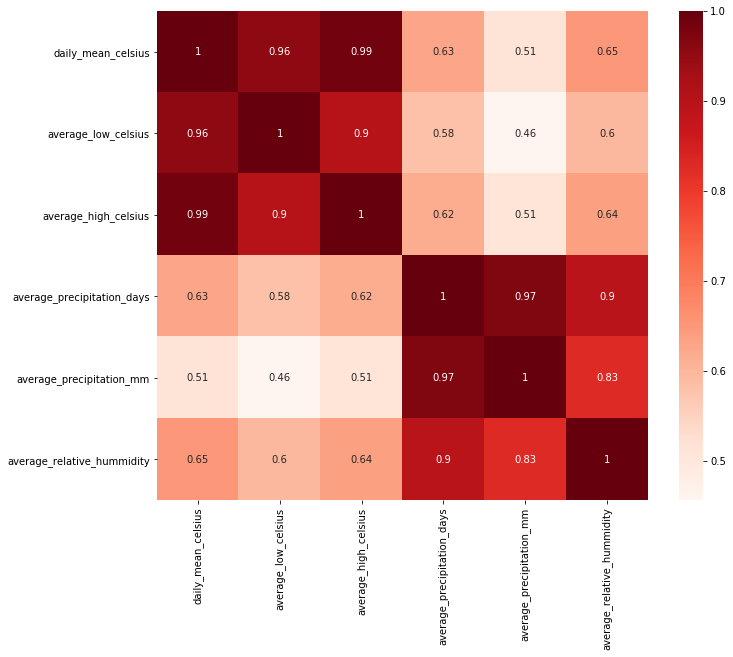

In [9]:
plt.figure(figsize=(11,9))
cor = df_full[["daily_mean_celsius","average_low_celsius","average_high_celsius",'average_precipitation_days',
       'average_precipitation_mm', 'average_relative_hummidity']].astype(str).astype(float).corr()
sb.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Since daily_mean_celsius, average_low_celsius, and average_high_celsius have strong positive correlation with each other, therefore I only keep daily_mean_celsius. 

Same thing happens with average_precipitation_days, average_precipitation_mm, and average_relative_hummidity. 3 of them also have strong positive correlation so I decided only to keep average_precipitation_mm.

# Train & Test Split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
features_df = df_full[['search_interest','average_precipitation_mm','daily_mean_celsius','australia','china','india','japan','malaysia','south_korea','united_states', 'apr', 'aug', 'dec', 'feb','jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']]

# Create the X and y arrays
X = features_df.as_matrix()
y = df_full['visitors'].as_matrix()

# Split the data set in a training set (80%) and a test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

c:\users\usuario\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
c:\users\usuario\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


# Build ML Model

For building a prediction model, I choose the Gradient Boosting and Random Forest algorithm. Both are an ensemble method, a technique that creates multiple models and then combines them to produce better results, in this case both Gradient Boosting and Random Forest generated multiple decision trees. So what is the difference between them? Gradient boosting using a method called “boosting” while random forest used a method called “bagging”. Boosting method is running iteratively, it evaluates what it gets right and what it gets wrong on that first tree, and then with the next iteration it places a heavier weight on those observations that it got wrong, this process continues until it has minimized the error as much as possible. The bagging method builds decision-trees simultaneously and later uses a voting method to combine the predictions of each.

In order to build the best model, I need to find the best value for each parameter of the model, this is something that is famously known as hyperparameter optimization. Usually, the value of hyperparameters is chosen randomly and then pick the hyperparameters value with the best accuracy result. But it can be a very exhausting process especially if there is more than one hyperparameter in one model, therefore it is better to use an algorithm to find the best hyperparameter combination automatically such as grid-search. By using scikit-learn library, the Grid Search algorithm can be implemented by importing a class called GridSearchCV.

In [12]:
# Parameters we want to try
param_grid = {
    'n_estimators': [100, 500, 1000, 3000],
    'max_depth': [5, 10, 30, 60, 100, None]
   
}

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble

In [14]:
# Define the grid search we want to run. For K-Fold cross validation I use K=5
gs_cv_gradient = GridSearchCV(ensemble.GradientBoostingRegressor(), param_grid, n_jobs=-1, cv = 5)
gs_cv_randomf = GridSearchCV(ensemble.RandomForestRegressor(), param_grid, n_jobs=-1, cv = 5)



In [15]:
# Run the grid search on the training data.
gs_cv_gradient.fit(X_train, y_train)
gs_cv_randomf.fit(X_train, y_train)

c:\users\usuario\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\usuario\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 500, 1000, 3000], 'max_depth': [5, 10, 30, 60, 100, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
gs_cv_gradient.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [17]:
gs_cv_randomf.best_params_

{'max_depth': 30, 'n_estimators': 100}

# Evaluation

To evaluate this model I calculate R-squared (R2) and mean absolute error (MAE). Both of this measurement are calculated using scikit-learn:

In [18]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [19]:
print('Mean Absolute Error for test set using Gradien Boost: '+str(mean_absolute_error(y_test, gs_cv_gradient.predict(X_test))))
print('r2 score Error for test set using Gradien Boost: '+str(r2_score(y_test, gs_cv_gradient.predict(X_test))))
print('Mean Absolute Error for test set using Random Forest: '+str(mean_absolute_error(y_test, gs_cv_randomf.predict(X_test))))
print('r2 score Error for test set using Random Forest: '+str(r2_score(y_test, gs_cv_randomf.predict(X_test))))

Mean Absolute Error for test set using Gradien Boost: 4649.737489202573
r2 score Error for test set using Gradien Boost: 0.9276705287499879
Mean Absolute Error for test set using Random Forest: 5524.1852941176485
r2 score Error for test set using Random Forest: 0.9156017419384601


# Feature Importance

Since both models are tree-based machine learning algorithms, we can actually rank all features based on how often they are used in determining the dependent variable. 

In [20]:
import numpy as np

In [21]:
# These are the feature labels from our data set
feature_labels = np.array(['search_interest','average_precipitation_mm','daily_mean_celsius','australia','china','india','japan','malaysia','south_korea','united_states', 'apr', 'aug', 'dec', 'feb','jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep'])

# Create a numpy array based on the model's feature importances
importance = gs_cv_gradient.best_estimator_.feature_importances_

# Sort the feature labels based on the feature importance rankings from the model
feauture_indexes_by_importance = importance.argsort()

# Print each feature label, from most important to least important (reverse order)
for index in feauture_indexes_by_importance:
    print("{} - {:.2f}%".format(feature_labels[index], (importance[index] * 100.0)))

apr - 0.00%
oct - 0.00%
jul - 0.01%
feb - 0.01%
aug - 0.01%
sep - 0.01%
jan - 0.01%
nov - 0.02%
dec - 0.04%
may - 0.05%
jun - 0.06%
south_korea - 0.07%
united_states - 0.09%
japan - 0.11%
mar - 0.13%
malaysia - 0.25%
search_interest - 1.21%
india - 1.31%
average_precipitation_mm - 1.55%
daily_mean_celsius - 1.56%
china - 40.07%
australia - 53.42%


In [22]:
# These are the feature labels from our data set
feature_labels = np.array(['search_interest','average_precipitation_mm','daily_mean_celsius','australia','china','india','japan','malaysia','south_korea','united_states', 'apr', 'aug', 'dec', 'feb','jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep'])

# Create a numpy array based on the model's feature importances
importance = gs_cv_randomf.best_estimator_.feature_importances_

# Sort the feature labels based on the feature importance rankings from the model
feauture_indexes_by_importance = importance.argsort()

# Print each feature label, from most important to least important (reverse order)
for index in feauture_indexes_by_importance:
    print("{} - {:.2f}%".format(feature_labels[index], (importance[index] * 100.0)))

apr - 0.01%
aug - 0.02%
jun - 0.04%
oct - 0.04%
dec - 0.06%
south_korea - 0.06%
jan - 0.06%
sep - 0.07%
jul - 0.07%
united_states - 0.09%
nov - 0.09%
japan - 0.09%
may - 0.09%
malaysia - 0.20%
mar - 0.22%
feb - 0.28%
search_interest - 0.84%
average_precipitation_mm - 1.08%
daily_mean_celsius - 1.34%
india - 1.35%
australia - 46.23%
china - 47.69%
